# Classifiers on Extracted Features
In this notebook the features extracted from the "Transfer Learning" notebook are used for training and evaluating different types of classifiers.

## Useful imports

In [1]:
from google.colab import drive
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow import keras

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Utils

In [ ]:
def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


def evaluate_model (model, X_test, y_test):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(X_test)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = y_test
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
def compile_model(model, optimizer='adam'):
  loss = 'binary_crossentropy'
  
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
  
GLOBAL_MODELS_FOLDER = '/content/drive/MyDrive/Quora/Models/Transfer Learning/'
HISTORIES_FOLDER = '/content/drive/MyDrive/Quora/Histories/Transfer Learning/'

def run_model (model, model_name, train_set, val_set, epochs = 4, monitor='val_loss', class_weight=None):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = GLOBAL_MODELS_FOLDER + model_name + '.h5'
  callbacks_list = [
                    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
                  tf.keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(x=train_ds,
                      validation_data=val_ds,
                      epochs=epochs,
                      callbacks=callbacks_list,
                      class_weight=class_weight)
  # save on Drive only the best model
  #shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')

  # save on Drive also the history object
  history_df = pd.DataFrame(history.history)
  with open(HISTORIES_FOLDER + model_name + '.csv', mode='w+') as f:
    history_df.to_csv(f)

  show_training_and_validation_performance(history)

## Load classes

In [ ]:
train_questions = pd.read_csv('/content/drive/MyDrive/Quora/Dataset/training.csv')
y_train = train_questions['is_duplicate'].values
del train_questions

val_questions = pd.read_csv('/content/drive/MyDrive/Quora/Dataset/validation.csv')
y_val = val_questions['is_duplicate'].values
del val_questions

test_questions = pd.read_csv('/content/drive/MyDrive/Quora/Dataset/test.csv')
y_test = test_questions['is_duplicate'].values
del test_questions

## Compute weights

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train.tolist())

class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.7919194738672034, 1: 1.3564005569348454}

## Sentence BERT (all-distilroberta-v1)
Retrieve the features extracted from sentence BERT:

In [ ]:
x_train = np.load('/content/drive/MyDrive/Quora/Features/all-distilroberta-v1/training/full_question_distilroberta.npy')
x_val = np.load('/content/drive/MyDrive/Quora/Features/all-distilroberta-v1/validation/full_question_distilroberta.npy')
x_test = np.load('/content/drive/MyDrive/Quora/Features/all-distilroberta-v1/test/full_question_distilroberta.npy')

In [ ]:
import gc
gc.collect()

359

Dataset creation:

In [ ]:
BATCH_SIZE = 128

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

In [ ]:
del x_val
del x_train
del y_train
del y_val

gc.collect()

44

### Neural Network with pace 128


In [2]:
def nn_pace128(feature_dimension = 1536):
  pace = 128

  input = keras.Input(shape=(feature_dimension,))
  dim = feature_dimension-pace
  x = keras.layers.Dense(dim, activation='relu', name='Dense1408')(input)
  while dim != 128:
      dim -= pace
      name = 'Dense' + str(dim)
      x = keras.layers.Dense(dim, activation='relu', name=name)(x)
  x = keras.layers.Dense(64, activation='relu', name='Dense64')(x)
  x = keras.layers.Dense(32, activation='relu', name='Dense32')(x)
  x = keras.layers.Dense(16, activation='relu', name='Dense16')(x)
  outputs = keras.layers.Dense(1, activation='sigmoid', name='prediction')(x)
  model = keras.Model(inputs=input, outputs=outputs)
  return model

In [3]:
model = nn_pace128()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1536)]            0         
                                                                 
 Dense1408 (Dense)           (None, 1408)              2164096   
                                                                 
 Dense1280 (Dense)           (None, 1280)              1803520   
                                                                 
 Dense1152 (Dense)           (None, 1152)              1475712   
                                                                 
 Dense1024 (Dense)           (None, 1024)              1180672   
                                                                 
 Dense896 (Dense)            (None, 896)               918400    
                                                                 
 Dense768 (Dense)            (None, 768)               688896

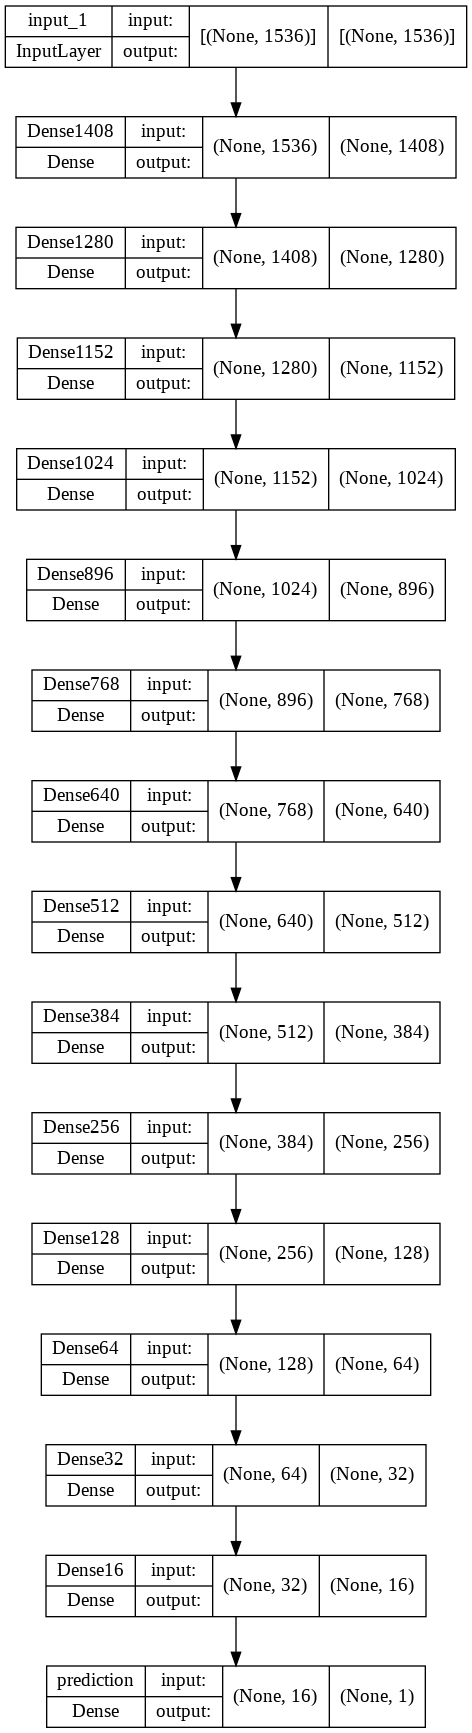

In [4]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
compile_model(model)

#### Experiment 1
In this experiment we use the original train_ds and val_ds for training.

Epoch 1/20
2527/2527 [==============================] - ETA: 0s - loss: 0.3984 - accuracy: 0.8081
Epoch 1: val_loss improved from inf to 0.33306, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace128.h5
2527/2527 [==============================] - 147s 53ms/step - loss: 0.3984 - accuracy: 0.8081 - val_loss: 0.3331 - val_accuracy: 0.8468
Epoch 2/20
2525/2527 [============================>.] - ETA: 0s - loss: 0.2970 - accuracy: 0.8658
Epoch 2: val_loss improved from 0.33306 to 0.32221, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace128.h5
2527/2527 [==============================] - 39s 15ms/step - loss: 0.2970 - accuracy: 0.8658 - val_loss: 0.3222 - val_accuracy: 0.8602
Epoch 3/20
2525/2527 [============================>.] - ETA: 0s - loss: 0.2446 - accuracy: 0.8934
Epoch 3: val_loss did not improve from 0.32221
2527/2527 [==============================] - 37s 14ms/step - loss: 0.2445 - accuracy: 0.8934

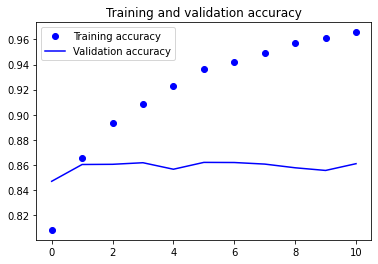

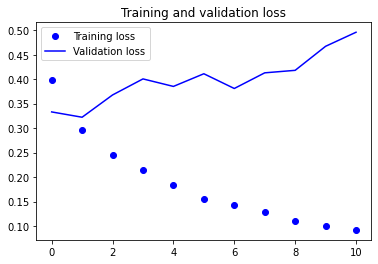

In [ ]:
run_model(model, 'distilroberta_DL_pace128', train_ds, val_ds, epochs=20)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace128.h5')

Classification report: 
              precision    recall  f1-score   support

           0     0.8933    0.8745    0.8838     25348
           1     0.7963    0.8244    0.8101     15080

    accuracy                         0.8558     40428
   macro avg     0.8448    0.8495    0.8469     40428
weighted avg     0.8571    0.8558    0.8563     40428



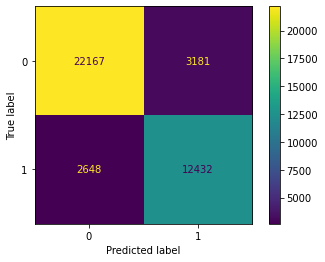

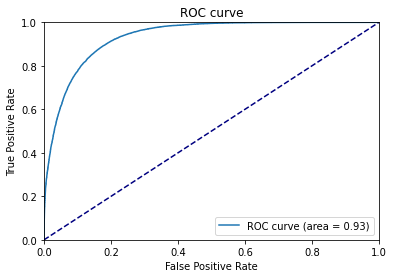

In [ ]:
evaluate_model(model, x_test, y_test)

#### Experiment 2: using class_weights

Epoch 1/20
2527/2527 [==============================] - ETA: 0s - loss: 0.4280 - accuracy: 0.7872
Epoch 1: val_loss improved from inf to 0.35120, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace128_weighted.h5
2527/2527 [==============================] - 39s 15ms/step - loss: 0.4280 - accuracy: 0.7872 - val_loss: 0.3512 - val_accuracy: 0.8382
Epoch 2/20
2526/2527 [============================>.] - ETA: 0s - loss: 0.3068 - accuracy: 0.8551
Epoch 2: val_loss improved from 0.35120 to 0.33173, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace128_weighted.h5
2527/2527 [==============================] - 38s 15ms/step - loss: 0.3067 - accuracy: 0.8552 - val_loss: 0.3317 - val_accuracy: 0.8514
Epoch 3/20
2526/2527 [============================>.] - ETA: 0s - loss: 0.2553 - accuracy: 0.8819
Epoch 3: val_loss improved from 0.33173 to 0.32964, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/

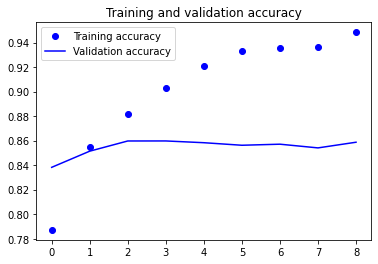

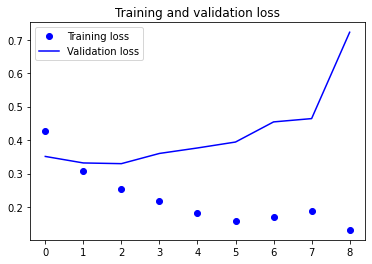

In [ ]:
run_model(model, 'distilroberta_DL_pace128_weighted', train_ds, val_ds, epochs=20, class_weight=class_weights)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace128_weighted.h5')

Classification report: 
              precision    recall  f1-score   support

           0     0.9157    0.8515    0.8824     25348
           1     0.7767    0.8682    0.8199     15080

    accuracy                         0.8577     40428
   macro avg     0.8462    0.8598    0.8511     40428
weighted avg     0.8638    0.8577    0.8591     40428



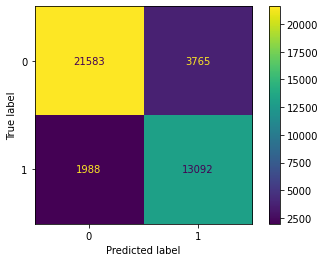

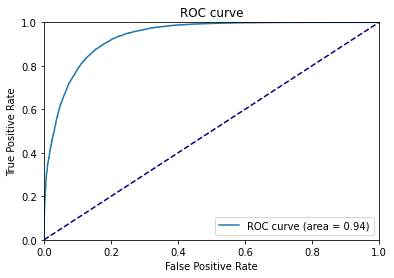

In [ ]:
evaluate_model(model, x_test, y_test)

### Neural Network with pace 64


In [5]:
def nn_pace64(feature_dimension = 1536):
  pace = 64

  input = keras.Input(shape=(feature_dimension,))
  dim = feature_dimension-pace
  x = keras.layers.Dense(dim, activation='relu', name='Dense1472')(input)
  while dim != 64:
      dim -= pace
      name = 'Dense' + str(dim)
      x = keras.layers.Dense(dim, activation='relu', name=name)(x)
  x = keras.layers.Dense(32, activation='relu', name='Dense32')(x)
  x = keras.layers.Dense(16, activation='relu', name='Dense16')(x)
  outputs = keras.layers.Dense(1, activation='sigmoid', name='prediction')(x)
  model = keras.Model(inputs=input, outputs=outputs)
  return model

In [6]:
model = nn_pace64()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1536)]            0         
                                                                 
 Dense1472 (Dense)           (None, 1472)              2262464   
                                                                 
 Dense1408 (Dense)           (None, 1408)              2073984   
                                                                 
 Dense1344 (Dense)           (None, 1344)              1893696   
                                                                 
 Dense1280 (Dense)           (None, 1280)              1721600   
                                                                 
 Dense1216 (Dense)           (None, 1216)              1557696   
                                                                 
 Dense1152 (Dense)           (None, 1152)              1401

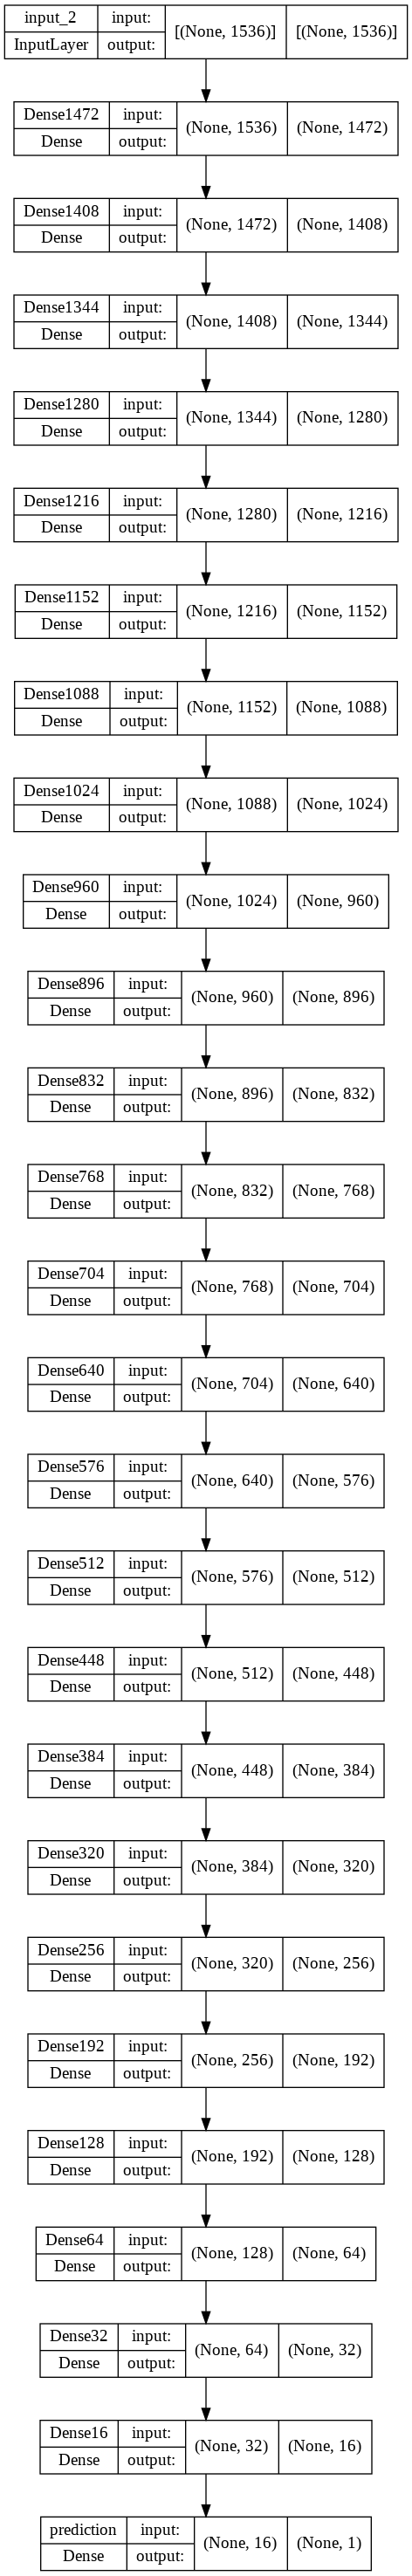

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
compile_model(model)

#### Experiment 1
In this experiment we use the original train_ds and val_ds for training.

Epoch 1/20
2526/2527 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.6312
Epoch 1: val_loss improved from inf to 0.65904, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace64.h5
2527/2527 [==============================] - 117s 44ms/step - loss: 0.6587 - accuracy: 0.6312 - val_loss: 0.6590 - val_accuracy: 0.6300
Epoch 2/20
2525/2527 [============================>.] - ETA: 0s - loss: 0.6248 - accuracy: 0.6608
Epoch 2: val_loss improved from 0.65904 to 0.46139, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace64.h5
2527/2527 [==============================] - 64s 25ms/step - loss: 0.6247 - accuracy: 0.6609 - val_loss: 0.4614 - val_accuracy: 0.7773
Epoch 3/20
2526/2527 [============================>.] - ETA: 0s - loss: 0.3810 - accuracy: 0.8220
Epoch 3: val_loss improved from 0.46139 to 0.37160, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pa

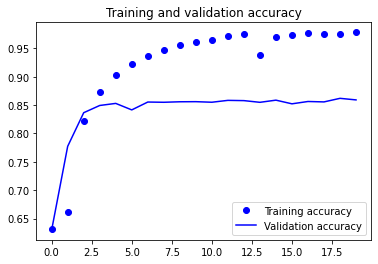

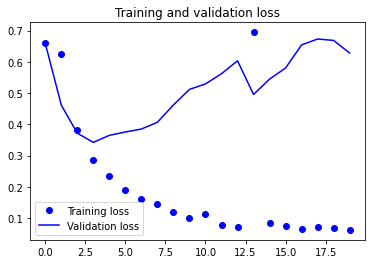

In [ ]:
run_model(model, 'distilroberta_DL_pace64', train_ds, val_ds, epochs=20)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace64.h5')

Classification report: 
              precision    recall  f1-score   support

           0     0.8842    0.8701    0.8771     25348
           1     0.7874    0.8084    0.7978     15080

    accuracy                         0.8471     40428
   macro avg     0.8358    0.8393    0.8374     40428
weighted avg     0.8481    0.8471    0.8475     40428



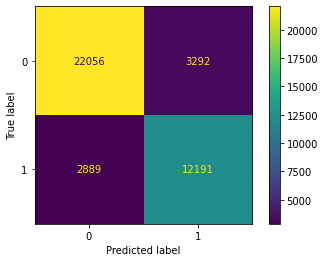

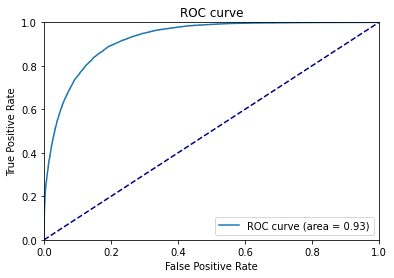

In [ ]:
evaluate_model(model, x_test, y_test)

#### Experiment 2: using class_weights

Epoch 1/20
2525/2527 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5230
Epoch 1: val_loss improved from inf to 0.69399, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace64_weighted.h5
2527/2527 [==============================] - 64s 25ms/step - loss: 0.6932 - accuracy: 0.5229 - val_loss: 0.6940 - val_accuracy: 0.3700
Epoch 2/20
2526/2527 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5060
Epoch 2: val_loss improved from 0.69399 to 0.69399, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace64_weighted.h5
2527/2527 [==============================] - 63s 25ms/step - loss: 0.6932 - accuracy: 0.5059 - val_loss: 0.6940 - val_accuracy: 0.3700
Epoch 3/20
2525/2527 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5060
Epoch 3: val_loss improved from 0.69399 to 0.69399, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/di

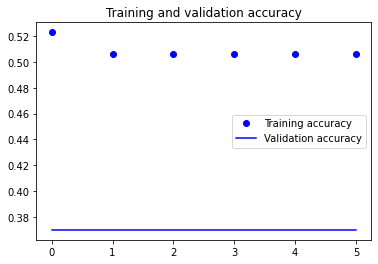

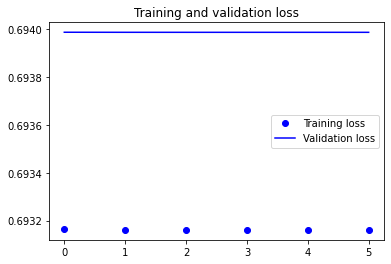

In [ ]:
run_model(model, 'distilroberta_DL_pace64_weighted', train_ds, val_ds, epochs=20, class_weight=class_weights)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace64_weighted.h5')

Classification report: 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     25348
           1     0.3730    1.0000    0.5433     15080

    accuracy                         0.3730     40428
   macro avg     0.1865    0.5000    0.2717     40428
weighted avg     0.1391    0.3730    0.2027     40428



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


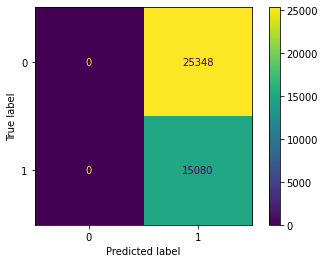

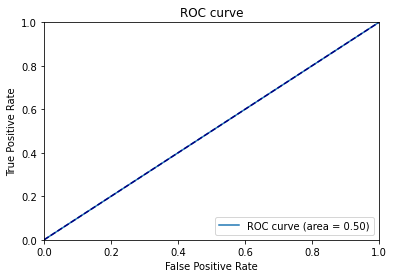

In [ ]:
evaluate_model(model, x_test, y_test)

### Neural Network with pace 256


In [8]:
def nn_pace256(feature_dimension = 1536):
  pace = 256

  input = keras.Input(shape=(feature_dimension,))
  dim = feature_dimension-pace
  x = keras.layers.Dense(dim, activation='relu', name='Dense1280')(input)
  while dim != 256:
      dim -= pace
      name = 'Dense' + str(dim)
      x = keras.layers.Dense(dim, activation='relu', name=name)(x)
  x = keras.layers.Dense(128, activation='relu', name='Dense128')(x)
  x = keras.layers.Dense(64, activation='relu', name='Dense64')(x)
  x = keras.layers.Dense(32, activation='relu', name='Dense32')(x)
  x = keras.layers.Dense(16, activation='relu', name='Dense16')(x)
  outputs = keras.layers.Dense(1, activation='sigmoid', name='prediction')(x)
  model = keras.Model(inputs=input, outputs=outputs)
  return model

In [9]:
model = nn_pace256()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1536)]            0         
                                                                 
 Dense1280 (Dense)           (None, 1280)              1967360   
                                                                 
 Dense1024 (Dense)           (None, 1024)              1311744   
                                                                 
 Dense768 (Dense)            (None, 768)               787200    
                                                                 
 Dense512 (Dense)            (None, 512)               393728    
                                                                 
 Dense256 (Dense)            (None, 256)               131328    
                                                                 
 Dense128 (Dense)            (None, 128)               3289

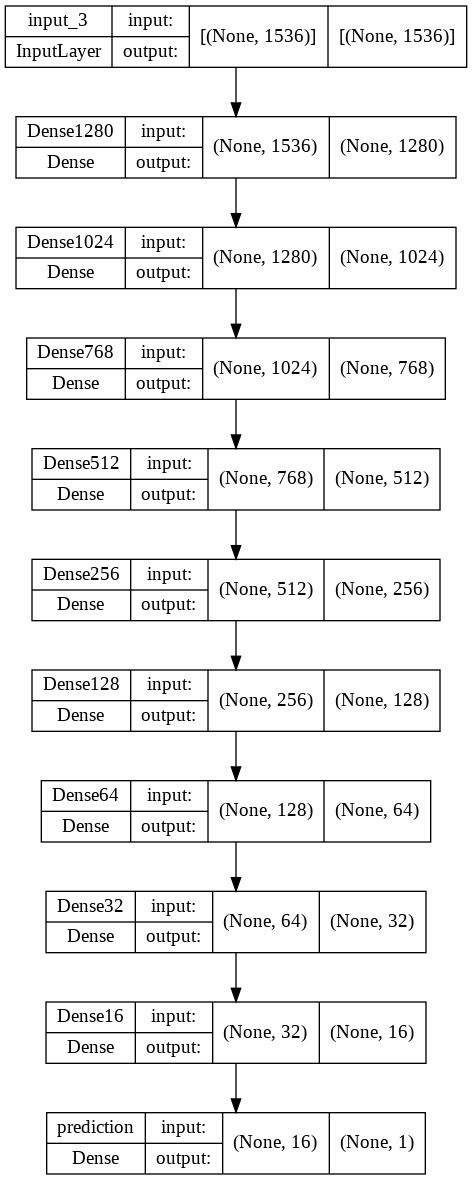

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
compile_model(model)

#### Experiment 1
In this experiment we use the original train_ds and val_ds for training.

Epoch 1/20
2526/2527 [============================>.] - ETA: 0s - loss: 0.3843 - accuracy: 0.8155
Epoch 1: val_loss improved from inf to 0.32828, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace256.h5
2527/2527 [==============================] - 33s 12ms/step - loss: 0.3842 - accuracy: 0.8155 - val_loss: 0.3283 - val_accuracy: 0.8488
Epoch 2/20
2527/2527 [==============================] - ETA: 0s - loss: 0.2827 - accuracy: 0.8736
Epoch 2: val_loss improved from 0.32828 to 0.32671, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace256.h5
2527/2527 [==============================] - 30s 12ms/step - loss: 0.2827 - accuracy: 0.8736 - val_loss: 0.3267 - val_accuracy: 0.8584
Epoch 3/20
2527/2527 [==============================] - ETA: 0s - loss: 0.2290 - accuracy: 0.8998
Epoch 3: val_loss did not improve from 0.32671
2527/2527 [==============================] - 31s 12ms/step - loss: 0.2290 - accuracy: 0.8998 

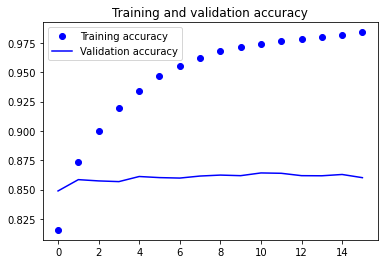

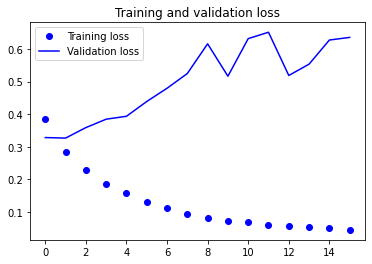

In [ ]:
run_model(model, 'distilroberta_DL_pace256', train_ds, val_ds, epochs=20)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace256.h5')

Classification report: 
              precision    recall  f1-score   support

           0     0.8776    0.8949    0.8862     25348
           1     0.8173    0.7903    0.8035     15080

    accuracy                         0.8559     40428
   macro avg     0.8475    0.8426    0.8449     40428
weighted avg     0.8551    0.8559    0.8554     40428



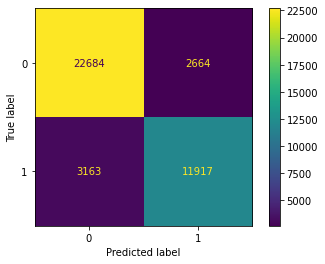

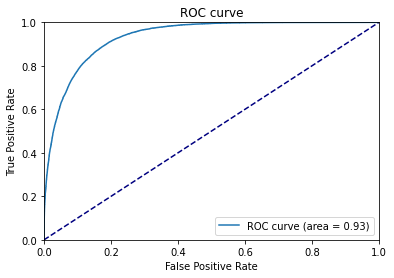

In [ ]:
evaluate_model(model, x_test, y_test)

#### Experiment 2: using class_weights

Epoch 1/20
2524/2527 [============================>.] - ETA: 0s - loss: 0.4033 - accuracy: 0.8004
Epoch 1: val_loss improved from inf to 0.34861, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace256_weighted.h5
2527/2527 [==============================] - 29s 11ms/step - loss: 0.4032 - accuracy: 0.8005 - val_loss: 0.3486 - val_accuracy: 0.8448
Epoch 2/20
2526/2527 [============================>.] - ETA: 0s - loss: 0.2894 - accuracy: 0.8651
Epoch 2: val_loss improved from 0.34861 to 0.32913, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace256_weighted.h5
2527/2527 [==============================] - 29s 11ms/step - loss: 0.2894 - accuracy: 0.8651 - val_loss: 0.3291 - val_accuracy: 0.8492
Epoch 3/20
2522/2527 [============================>.] - ETA: 0s - loss: 0.2353 - accuracy: 0.8925
Epoch 3: val_loss improved from 0.32913 to 0.32911, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/

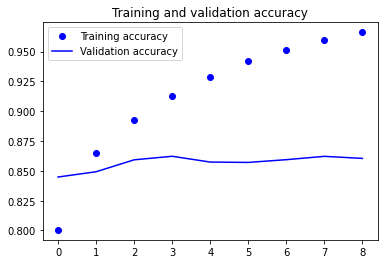

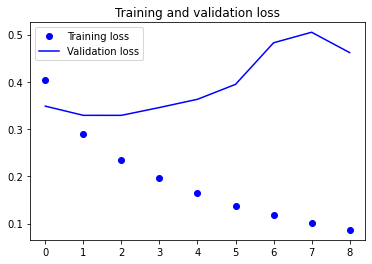

In [ ]:
run_model(model, 'distilroberta_DL_pace256_weighted', train_ds, val_ds, epochs=20, class_weight=class_weights)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace256_weighted.h5')

Classification report: 
              precision    recall  f1-score   support

           0     0.9023    0.8689    0.8853     25348
           1     0.7926    0.8418    0.8165     15080

    accuracy                         0.8588     40428
   macro avg     0.8474    0.8554    0.8509     40428
weighted avg     0.8614    0.8588    0.8596     40428



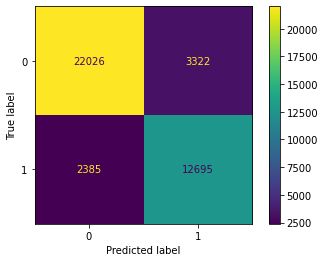

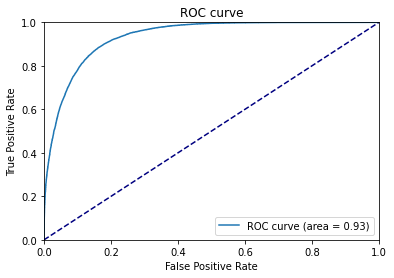

In [ ]:
evaluate_model(model, x_test, y_test)

### Neural Network with pace 512


In [11]:
def nn_pace512(feature_dimension = 1536):
  pace = 512

  input = keras.Input(shape=(feature_dimension,))
  dim = feature_dimension-pace
  x = keras.layers.Dense(dim, activation='relu', name='Dense1024')(input)
  while dim != 512:
      dim -= pace
      name = 'Dense' + str(dim)
      x = keras.layers.Dense(dim, activation='relu', name=name)(x)
  x = keras.layers.Dense(128, activation='relu', name='Dense128')(x)
  x = keras.layers.Dense(64, activation='relu', name='Dense64')(x)
  x = keras.layers.Dense(16, activation='relu', name='Dense16')(x)
  outputs = keras.layers.Dense(1, activation='sigmoid', name='prediction')(x)
  model = keras.Model(inputs=input, outputs=outputs)
  return model

In [12]:
model = nn_pace512()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1536)]            0         
                                                                 
 Dense1024 (Dense)           (None, 1024)              1573888   
                                                                 
 Dense512 (Dense)            (None, 512)               524800    
                                                                 
 Dense128 (Dense)            (None, 128)               65664     
                                                                 
 Dense64 (Dense)             (None, 64)                8256      
                                                                 
 Dense16 (Dense)             (None, 16)                1040      
                                                                 
 prediction (Dense)          (None, 1)                 17  

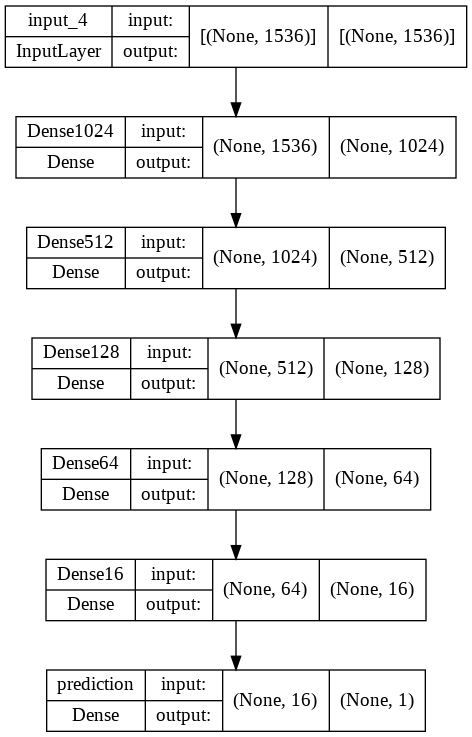

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
compile_model(model)

#### Experiment 1
In this experiment we use the original train_ds and val_ds for training.

Epoch 1/20
2527/2527 [==============================] - ETA: 0s - loss: 0.3794 - accuracy: 0.8186
Epoch 1: val_loss improved from inf to 0.32245, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace512.h5
2527/2527 [==============================] - 27s 10ms/step - loss: 0.3794 - accuracy: 0.8186 - val_loss: 0.3225 - val_accuracy: 0.8525
Epoch 2/20
2521/2527 [============================>.] - ETA: 0s - loss: 0.2746 - accuracy: 0.8773
Epoch 2: val_loss improved from 0.32245 to 0.32140, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace512.h5
2527/2527 [==============================] - 21s 8ms/step - loss: 0.2745 - accuracy: 0.8774 - val_loss: 0.3214 - val_accuracy: 0.8568
Epoch 3/20
2520/2527 [============================>.] - ETA: 0s - loss: 0.2204 - accuracy: 0.9048
Epoch 3: val_loss did not improve from 0.32140
2527/2527 [==============================] - 20s 8ms/step - loss: 0.2203 - accuracy: 0.9049 - 

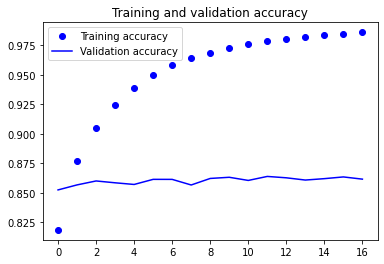

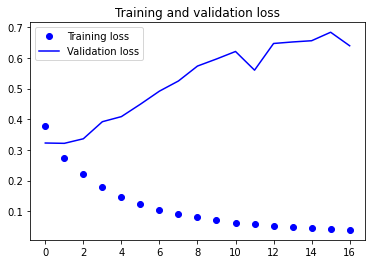

In [ ]:
run_model(model, 'distilroberta_DL_pace512', train_ds, val_ds, epochs=20)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace512.h5')

Classification report: 
              precision    recall  f1-score   support

           0     0.8775    0.8991    0.8882     25348
           1     0.8231    0.7889    0.8056     15080

    accuracy                         0.8580     40428
   macro avg     0.8503    0.8440    0.8469     40428
weighted avg     0.8572    0.8580    0.8574     40428



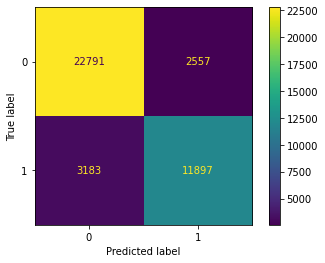

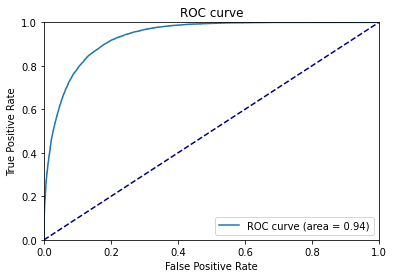

In [ ]:
evaluate_model(model, x_test, y_test)

#### Experiment 2: using class_weights

Epoch 1/20
2523/2527 [============================>.] - ETA: 0s - loss: 0.3938 - accuracy: 0.8075
Epoch 1: val_loss improved from inf to 0.33755, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace512_weighted.h5
2527/2527 [==============================] - 22s 8ms/step - loss: 0.3937 - accuracy: 0.8075 - val_loss: 0.3376 - val_accuracy: 0.8451
Epoch 2/20
2527/2527 [==============================] - ETA: 0s - loss: 0.2814 - accuracy: 0.8682
Epoch 2: val_loss improved from 0.33755 to 0.32310, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace512_weighted.h5
2527/2527 [==============================] - 21s 8ms/step - loss: 0.2814 - accuracy: 0.8682 - val_loss: 0.3231 - val_accuracy: 0.8585
Epoch 3/20
2525/2527 [============================>.] - ETA: 0s - loss: 0.2281 - accuracy: 0.8951
Epoch 3: val_loss did not improve from 0.32310
2527/2527 [==============================] - 20s 8ms/step - loss: 0.2280 - ac

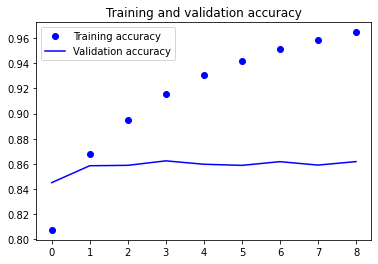

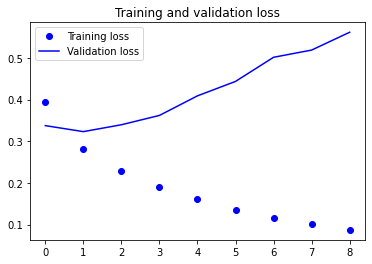

In [ ]:
run_model(model, 'distilroberta_DL_pace512_weighted', train_ds, val_ds, epochs=20, class_weight=class_weights)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace512_weighted.h5')

Classification report: 
              precision    recall  f1-score   support

           0     0.9136    0.8490    0.8802     25348
           1     0.7732    0.8651    0.8166     15080

    accuracy                         0.8550     40428
   macro avg     0.8434    0.8571    0.8484     40428
weighted avg     0.8613    0.8550    0.8564     40428



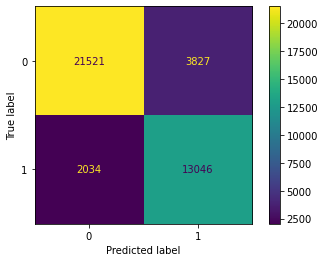

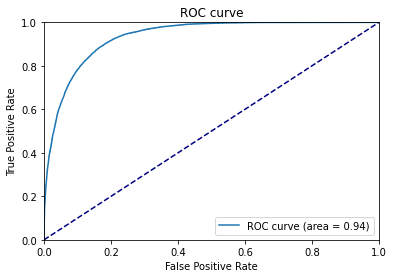

In [ ]:
evaluate_model(model, x_test, y_test)

### Neural Network with halving 2


In [14]:
def nn_halving2(feature_dimension = 1536):
  input = keras.Input(shape=(feature_dimension,))
  dim = feature_dimension/2
  x = keras.layers.Dense(dim, activation='relu', name='Dense768')(input)
  while dim != 48:
      dim /= 2
      name = 'Dense' + str(dim)
      x = keras.layers.Dense(dim, activation='relu', name=name)(x)
  outputs = keras.layers.Dense(1, activation='sigmoid', name='prediction')(x)
  model = keras.Model(inputs=input, outputs=outputs)
  return model

In [15]:
model = nn_halving2()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1536)]            0         
                                                                 
 Dense768 (Dense)            (None, 768)               1180416   
                                                                 
 Dense384.0 (Dense)          (None, 384)               295296    
                                                                 
 Dense192.0 (Dense)          (None, 192)               73920     
                                                                 
 Dense96.0 (Dense)           (None, 96)                18528     
                                                                 
 Dense48.0 (Dense)           (None, 48)                4656      
                                                                 
 prediction (Dense)          (None, 1)                 49  

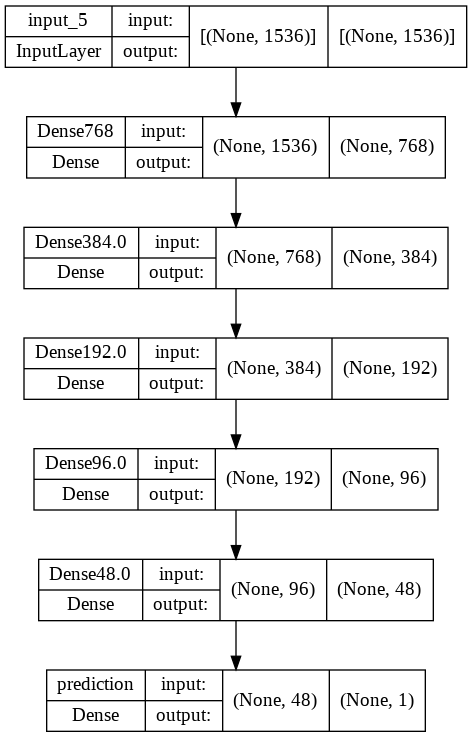

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
compile_model(model)

#### Experiment 1
In this experiment we use the original train_ds and val_ds for training.

Epoch 1/20
2527/2527 [==============================] - ETA: 0s - loss: 0.3791 - accuracy: 0.8192
Epoch 1: val_loss improved from inf to 0.32494, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_halving2.h5
2527/2527 [==============================] - 28s 10ms/step - loss: 0.3791 - accuracy: 0.8192 - val_loss: 0.3249 - val_accuracy: 0.8504
Epoch 2/20
2520/2527 [============================>.] - ETA: 0s - loss: 0.2770 - accuracy: 0.8758
Epoch 2: val_loss improved from 0.32494 to 0.31948, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_halving2.h5
2527/2527 [==============================] - 19s 8ms/step - loss: 0.2769 - accuracy: 0.8758 - val_loss: 0.3195 - val_accuracy: 0.8576
Epoch 3/20
2524/2527 [============================>.] - ETA: 0s - loss: 0.2242 - accuracy: 0.9030
Epoch 3: val_loss did not improve from 0.31948
2527/2527 [==============================] - 18s 7ms/step - loss: 0.2241 - accuracy: 0.9030 

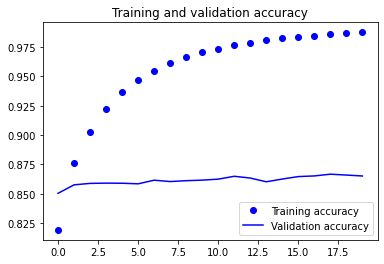

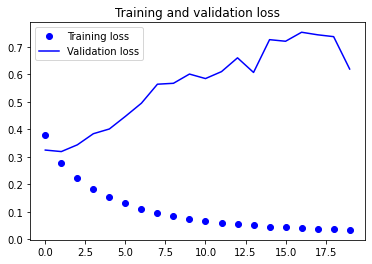

In [ ]:
run_model(model, 'distilroberta_DL_halving2', train_ds, val_ds, epochs=20)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_halving2.h5')

Classification report: 
              precision    recall  f1-score   support

           0     0.8767    0.8991    0.8878     25348
           1     0.8228    0.7875    0.8048     15080

    accuracy                         0.8575     40428
   macro avg     0.8498    0.8433    0.8463     40428
weighted avg     0.8566    0.8575    0.8568     40428



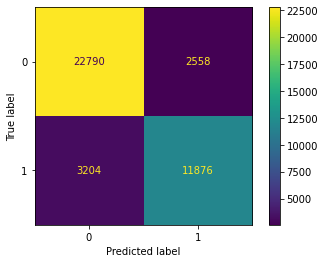

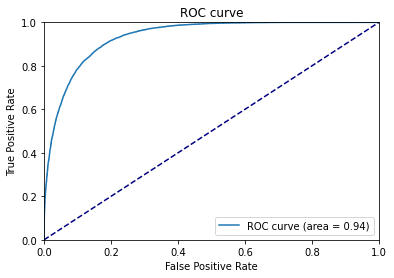

In [ ]:
evaluate_model(model, x_test, y_test)

#### Experiment 2: using class_weights

Epoch 1/20
2527/2527 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.8063
Epoch 1: val_loss improved from inf to 0.33754, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_halving2_weighted.h5
2527/2527 [==============================] - 20s 7ms/step - loss: 0.3950 - accuracy: 0.8063 - val_loss: 0.3375 - val_accuracy: 0.8433
Epoch 2/20
2522/2527 [============================>.] - ETA: 0s - loss: 0.2831 - accuracy: 0.8677
Epoch 2: val_loss improved from 0.33754 to 0.32075, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_halving2_weighted.h5
2527/2527 [==============================] - 19s 8ms/step - loss: 0.2831 - accuracy: 0.8677 - val_loss: 0.3208 - val_accuracy: 0.8584
Epoch 3/20
2525/2527 [============================>.] - ETA: 0s - loss: 0.2309 - accuracy: 0.8946
Epoch 3: val_loss did not improve from 0.32075
2527/2527 [==============================] - 18s 7ms/step - loss: 0.2309 - 

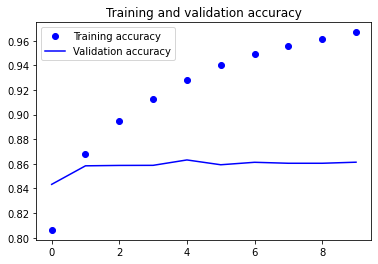

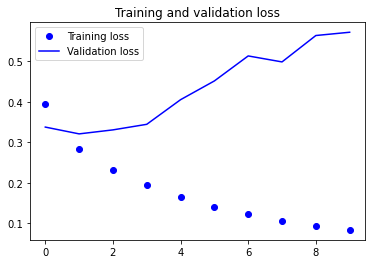

In [ ]:
run_model(model, 'distilroberta_DL_halving2_weighted', train_ds, val_ds, epochs=20, class_weight=class_weights)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_halving2_weighted.h5')

Classification report: 
              precision    recall  f1-score   support

           0     0.9040    0.8702    0.8868     25348
           1     0.7948    0.8447    0.8190     15080

    accuracy                         0.8607     40428
   macro avg     0.8494    0.8575    0.8529     40428
weighted avg     0.8633    0.8607    0.8615     40428



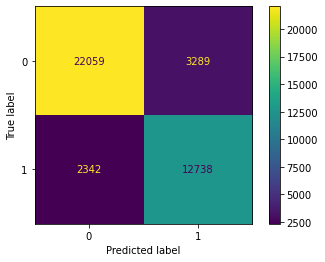

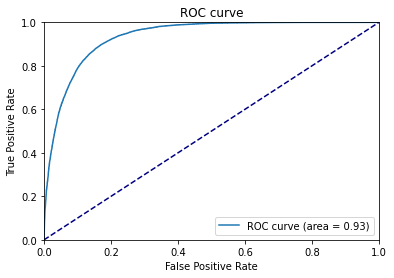

In [ ]:
evaluate_model(model, x_test, y_test)

### Neural Network with halving 4


In [17]:
def nn_halving4(feature_dimension = 1536):
  input = keras.Input(shape=(feature_dimension,))
  dim = feature_dimension/4
  x = keras.layers.Dense(dim, activation='relu', name='Dense384')(input)
  while dim != 24:
      dim /= 4
      name = 'Dense' + str(dim)
      x = keras.layers.Dense(dim, activation='relu', name=name)(x)
  outputs = keras.layers.Dense(1, activation='sigmoid', name='prediction')(x)
  model = keras.Model(inputs=input, outputs=outputs)
  return model

In [18]:
model = nn_halving4()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1536)]            0         
                                                                 
 Dense384 (Dense)            (None, 384)               590208    
                                                                 
 Dense96.0 (Dense)           (None, 96)                36960     
                                                                 
 Dense24.0 (Dense)           (None, 24)                2328      
                                                                 
 prediction (Dense)          (None, 1)                 25        
                                                                 
Total params: 629,521
Trainable params: 629,521
Non-trainable params: 0
_________________________________________________________________


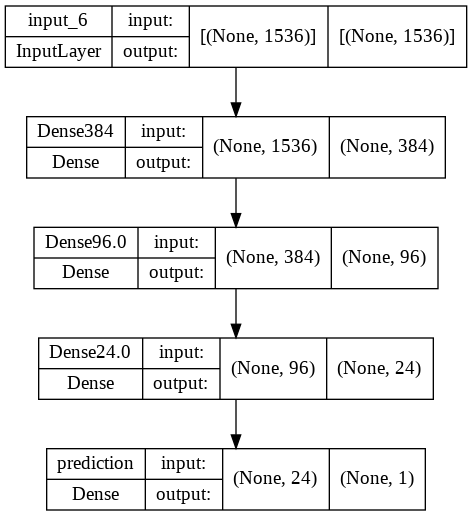

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
compile_model(model)

#### Experiment 1
In this experiment we use the original train_ds and val_ds for training.

Epoch 1/20
2518/2527 [============================>.] - ETA: 0s - loss: 0.3881 - accuracy: 0.8148
Epoch 1: val_loss improved from inf to 0.32901, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_halving4.h5
2527/2527 [==============================] - 17s 6ms/step - loss: 0.3878 - accuracy: 0.8150 - val_loss: 0.3290 - val_accuracy: 0.8488
Epoch 2/20
2525/2527 [============================>.] - ETA: 0s - loss: 0.2830 - accuracy: 0.8738
Epoch 2: val_loss improved from 0.32901 to 0.31846, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_halving4.h5
2527/2527 [==============================] - 16s 6ms/step - loss: 0.2830 - accuracy: 0.8738 - val_loss: 0.3185 - val_accuracy: 0.8588
Epoch 3/20
2521/2527 [============================>.] - ETA: 0s - loss: 0.2358 - accuracy: 0.8993
Epoch 3: val_loss did not improve from 0.31846
2527/2527 [==============================] - 15s 6ms/step - loss: 0.2357 - accuracy: 0.8993 -

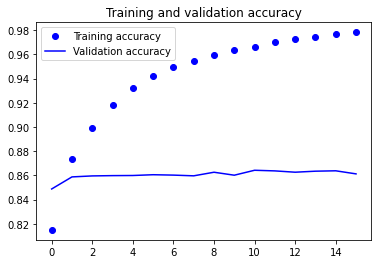

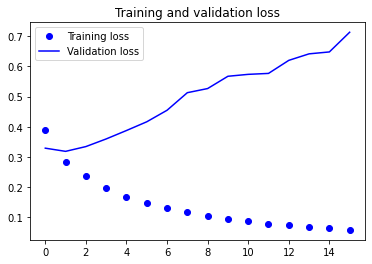

In [ ]:
run_model(model, 'distilroberta_DL_halving4', train_ds, val_ds, epochs=20)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_halving4.h5')

Classification report: 
              precision    recall  f1-score   support

           0     0.8717    0.8991    0.8852     25348
           1     0.8209    0.7777    0.7987     15080

    accuracy                         0.8538     40428
   macro avg     0.8463    0.8384    0.8420     40428
weighted avg     0.8528    0.8538    0.8529     40428



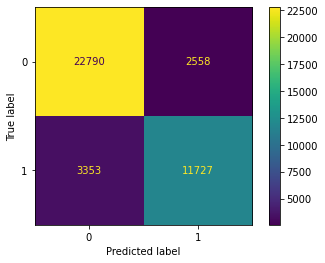

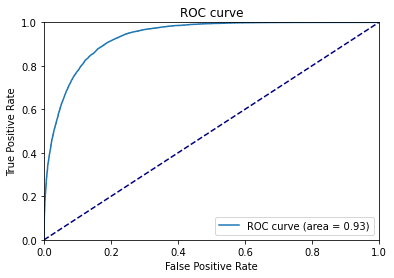

In [ ]:
evaluate_model(model, x_test, y_test)

#### Experiment 2: using class_weights

Epoch 1/20
2523/2527 [============================>.] - ETA: 0s - loss: 0.3972 - accuracy: 0.8059
Epoch 1: val_loss improved from inf to 0.34122, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_halving4_weighted.h5
2527/2527 [==============================] - 16s 6ms/step - loss: 0.3972 - accuracy: 0.8059 - val_loss: 0.3412 - val_accuracy: 0.8437
Epoch 2/20
2525/2527 [============================>.] - ETA: 0s - loss: 0.2881 - accuracy: 0.8668
Epoch 2: val_loss improved from 0.34122 to 0.32509, saving model to /content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_halving4_weighted.h5
2527/2527 [==============================] - 15s 6ms/step - loss: 0.2881 - accuracy: 0.8668 - val_loss: 0.3251 - val_accuracy: 0.8563
Epoch 3/20
2520/2527 [============================>.] - ETA: 0s - loss: 0.2399 - accuracy: 0.8918
Epoch 3: val_loss did not improve from 0.32509
2527/2527 [==============================] - 15s 6ms/step - loss: 0.2398 - 

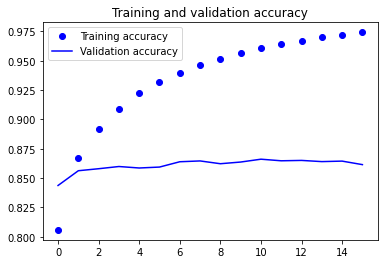

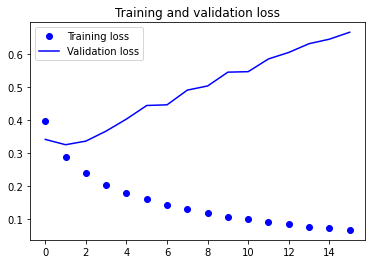

In [ ]:
run_model(model, 'distilroberta_DL_halving4_weighted', train_ds, val_ds, epochs=20, class_weight=class_weights)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_halving4_weighted.h5')

Classification report: 
              precision    recall  f1-score   support

           0     0.9142    0.8472    0.8794     25348
           1     0.7713    0.8664    0.8161     15080

    accuracy                         0.8544     40428
   macro avg     0.8428    0.8568    0.8478     40428
weighted avg     0.8609    0.8544    0.8558     40428



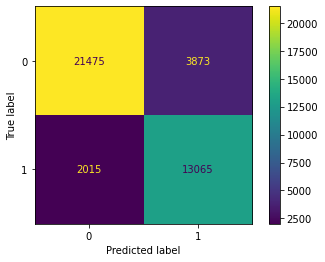

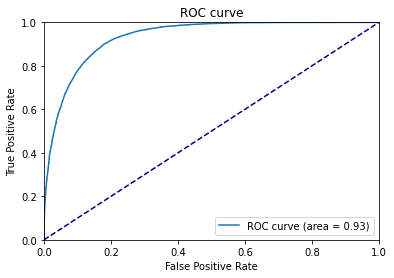

In [ ]:
evaluate_model(model, x_test, y_test)